## Упражнение 4.1


In [1]:
import numpy as np
import sys
import pandas as pd
sys.path.append('../')
from thinkdsp import read_wave, decorate, Wave, Spectrum, Noise
import thinkplot as tplt

Файлы *thunderstorm.wav* и *fireplace.wav* были загружены с сайта <https://freesound.org> по ссылкам <https://freesound.org/people/OroborosNZ/sounds/141251/> и <https://freesound.org/people/inchadney/sounds/83986/> соответственно. Оба файла были так же укорочены до трех минут для экономии места.

Прослушаем эти звуки и распечатаем их спектр

-1.0982385291901469


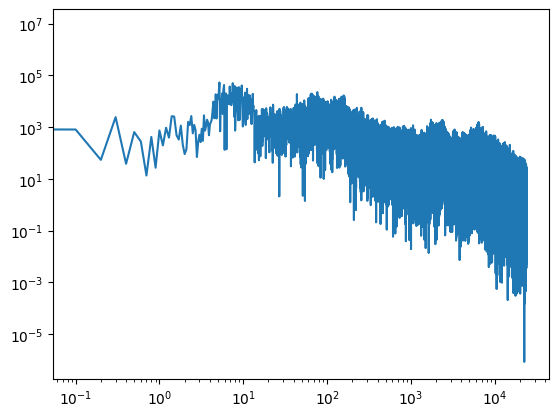

In [2]:
fireplace = read_wave('fireplace.wav').segment(start=5, duration=10)
thunderstorm = read_wave('thunderstorm.wav').segment(start=5, duration=10)

tplt.config(xscale='log', yscale='log')

f_spec = fireplace.make_spectrum()
f_spec.plot_power()

print(f_spec.estimate_slope()[0])
fireplace.make_audio()

-2.3560062759263096


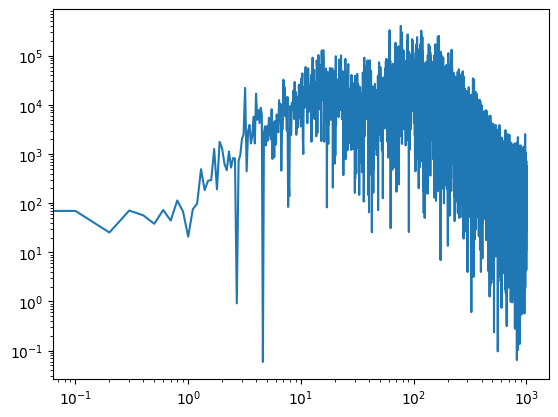

In [3]:
tplt.config(xscale='log', yscale='log')

t_spec = thunderstorm.make_spectrum()
t_spec.plot_power(high=1000)

print(t_spec.estimate_slope()[0])
thunderstorm.make_audio()

Звук камина *fireplace.wav* является розовым шумом так как наклон спектра составляет -1.1, в то время как звук грозового шторма *thunderstorm.wav* ближе всего к красному шуму с углом наклона спектра равным 2.36

## Упражнение 4.2

Реализация метода Бартлетта

In [4]:
def bartlett_method(wave, seg_length=512, win_flag=True):
    sp = wave.make_spectrogram(seg_length, win_flag)
    specs = sp.spec_map.values()

    psds = [spectrum.power for spectrum in specs]
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(specs)).fs

    return Spectrum(hs, fs, wave.framerate)

Используем его для оценки мощности звукового сигнала из упражнения 4.1

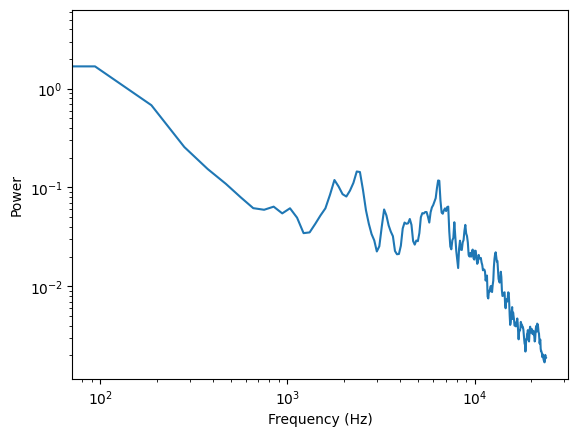

In [5]:
from thinkplot import Config

psd = bartlett_method(fireplace)
psd.plot_power()
Config(xlabel='Frequency (Hz)', ylabel='Power', xscale='log', yscale='log')

Скачаем файл с историческими данными о цене биткоина, файл был скачан с сайта https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data?resource=download. Были взяты только последние 100.000 строк для уменьшения размера файла.

ВЫчислим спектр цен как функцию времени

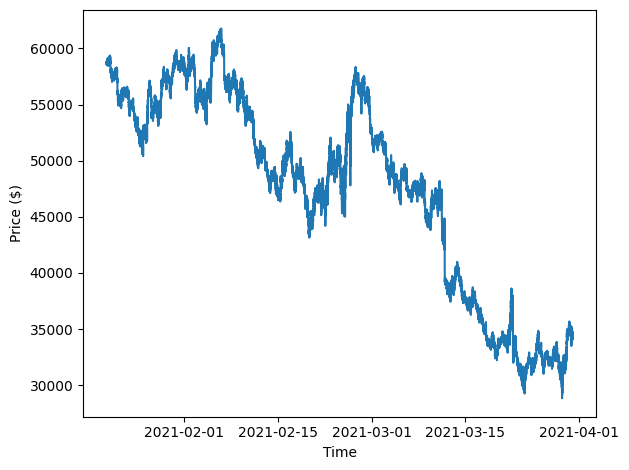

In [16]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from thinkdsp import Wave

df = pd.read_csv('bitcoin-historical.csv')
df.set_index('Timestamp', inplace=True)

ys = df['close']
ys = np.flip(ys)
ts = df.index
dt = pd.to_datetime(df.index, unit='s')

bit_wave = Wave(ys, ts, framerate=1)

plt.plot(dt, ys)
decorate(xlabel='Time', ylabel='Price ($)')

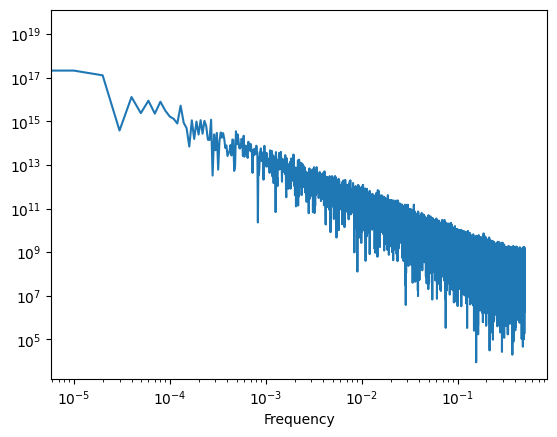

In [7]:
spectrum = bit_wave.make_spectrum()
spectrum.plot_power()
Config(xlabel='Frequency', xscale='log', yscale='log')

In [8]:
spectrum.estimate_slope()[0]

-1.7982562246853633

Наклон спектра приблизительно равен 1.8, что ближе всего к красному шуму, наклон которого равен 2.

## Упражнение 4.4
Напишем класс UncorrelatedPoissonNoise, наследующий thinkdsp._Noise, который моделирует некоррелированный пуассоновский шум (UP). И сгенерируем две секунды сигнала

In [9]:
class UncorrelatedPoissonNoise(Noise):
    """Represents Uncorrelated Poisson noise."""

    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        Computes Uncorrelated Poisson noise by taking the cumulative sum of
        a uniform random series.

        ts: float array of times

        returns: float wave array
        """
        ys = np.random.poisson(self.amp, len(ts))
        return ys

signal = UncorrelatedPoissonNoise(amp=0.0025)
wave = signal.make_wave(duration=2, framerate=10000)
wave.make_audio()

Треск действительно очень похож на счетчик Гейгера.

Найдем мощность сигнала

-0.014326812398616249


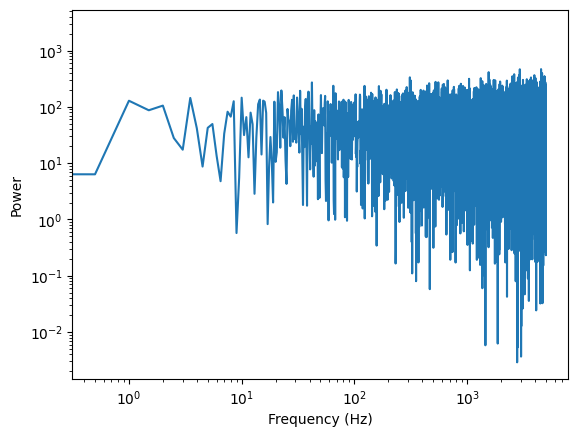

In [10]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
print(spectrum.estimate_slope()[0])
Config(xlabel='Frequency (Hz)', ylabel='Power', xscale='log', yscale='log')

При больших значениях амплитуды сигнал слышится как белый шум

In [11]:
signal = UncorrelatedPoissonNoise(amp=0.5)
wave = signal.make_wave(duration=2, framerate=10000)
wave.make_audio()

0.004827214689674287


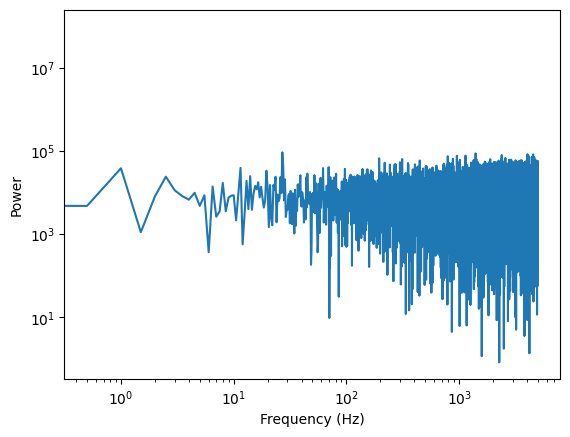

In [12]:

spectrum = wave.make_spectrum()
spectrum.plot_power()
print(spectrum.estimate_slope()[0])
Config(xlabel='Frequency (Hz)', ylabel='Power', xscale='log', yscale='log')

## Упражнение 4.5
Напишем алгоритм для генерации розового шума Vass-McCartney и вычислим спектр сгенерированного сигнала

In [13]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.

    nrows: number of values to generate
    rcols: number of random sources to add

    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)

    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.ffill(axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

signal = voss(10000)
ts = np.arange(len(signal))
wave = Wave(signal, ts, framerate=5000)
wave.make_audio()

-1.0047657019225469


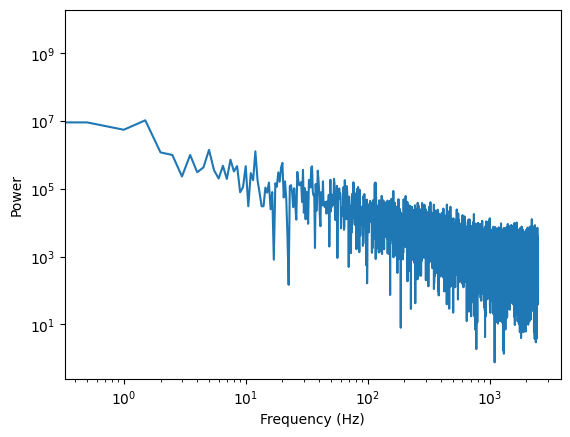

In [14]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
print(spectrum.estimate_slope()[0])
Config(xlabel='Frequency (Hz)', ylabel='Power', xscale='log', yscale='log')

Соотношение между мощностью и частотой соответствует розовому шуму.